# Visualization of MAE loss and segmentation loss

The hypothesis is that ...


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from mmcv.utils import Config
from mmcv.runner import wrap_fp16_model
from mmcv.runner.checkpoint import load_checkpoint
from mmseg.models import EncoderDecoder
from mmseg.models import build_segmentor
from mmseg.datasets import build_dataset
from scipy.stats import pearsonr
# required imports for customized modules to be in registry
from segal.method.segmentor import MultiTaskSegmentor
from segal.method.mae_decoder import MaskDecodeHead
from segal.losses.reconstruction_loss import ReconstructionLoss
# main function
from plotting.main import engine
from plotting.utils import get_seg_ranking, get_mae_ranking

## set up basic configs

In [2]:
""" segmenter model configs """
### normal supervised training ###
segmenter_file = 'almma/models/segmenter_linear_vit-b16.py'
# segmenter_checkpoint = "work_dirs/full_supervision_baseline/iter_128000.pth"  # strong
# segmenter_checkpoint = "work_dirs/full_supervision_baseline/iter_16000.pth"   # weak
### multitask trained ###
segmenter_checkpoint = "work_dirs/multitask_ra_lr5e-4_m50_1500warmup_e35/epoch_10.pth"
model_cfg = Config.fromfile(segmenter_file)

""" MAE model (ViT-base/16) configs """
mae_model_file = 'almma/models/twin_segmenter.py'
# mae_checkpoint = "work_dirs/warmup/iter_500.pth"
mae_checkpoint = "work_dirs/multitask_ra_lr5e-4_m50_1500warmup_e35/epoch_10.pth"
# mae_checkpoint = "/home/yutengli/workspace/vit_pretrained_checkpoints/mae_visualize_vit_base_mmcv.pth"
mae_cfg = Config.fromfile(mae_model_file)

""" data configs """
cityscapes_file = 'almma/dataset/cityscapes.py'
data_root = '/shared/yutengli/data/cityscapes/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
# scale_size = (1200, 600) # (width, height) by mmcv convention
scale_size = (800, 400) # (width, height) by mmcv convention
crop_size = (384, 384)
pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=scale_size),
    # dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', 
        keys=['img', 'gt_semantic_seg'], 
        meta_keys=('filename', 'ori_filename', 'ori_shape', 
                   'img_shape', 'scale_factor', 'img_norm_cfg')
    )
]

data_config = dict(
    samples_per_gpu=1,
    workers_per_gpu=4, 
    query=dict(
        type='CityscapesDataset',
        data_root=data_root,
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=pipeline
    )
)

## build segmenter and MAE models

In [3]:
""" create segmenter model and load to gpu """
print("building segmenter model (only uses decode head)...")
segmenter: EncoderDecoder = build_segmentor(
    model_cfg.model, model_cfg.get('train_cfg'), model_cfg.get('test_cfg'))
wrap_fp16_model(segmenter)
_ = load_checkpoint(segmenter, filename=segmenter_checkpoint)

""" create MAE model and load to gpu """
print("building mae model (only uses auxiliary head)...")
mae_model: MultiTaskSegmentor = build_segmentor(
    mae_cfg.model, mae_cfg.get('train_cfg'), mae_cfg.get('test_cfg'))
wrap_fp16_model(mae_model)
_ = load_checkpoint(mae_model, filename=mae_checkpoint)


""" create dataset """
dataset = build_dataset(data_config['query'], dict(test_mode=False))

building segmenter model (only uses decode head)...


/home/yutengli/workspace/segal/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: work_dirs/multitask_ra_lr5e-4_m50_1500warmup_e35/epoch_10.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: auxiliary_head.mask_token, auxiliary_head.pos_embed, auxiliary_head.layers.0.ln1.weight, auxiliary_head.layers.0.ln1.bias, auxiliary_head.layers.0.attn.attn.in_proj_weight, auxiliary_head.layers.0.attn.attn.in_proj_bias, auxiliary_head.layers.0.attn.attn.out_proj.weight, auxiliary_head.layers.0.attn.attn.out_proj.bias, auxiliary_head.layers.0.ln2.weight, auxiliary_head.layers.0.ln2.bias, auxiliary_head.layers.0.ffn.layers.0.0.weight, auxiliary_head.layers.0.ffn.layers.0.0.bias, auxiliary_head.layers.0.ffn.layers.1.weight, auxiliary_head.layers.0.ffn.layers.1.bias, auxiliary_head.layers.1.ln1.weight, auxiliary_head.layers.1.ln1.bias, auxiliary_head.layers.1.attn.attn.in_proj_weight, auxiliary_head.layers.1.attn.attn.in_proj_bias, auxiliary_head.layers.1.attn.attn.out_proj.weight, auxiliary_head.layers.1.

2023-04-28 19:34:50,350 - mmseg - INFO - Loaded 2975 images


In [12]:
from segal.active.heuristics import MaskPredictionScore, RegionImpurity
from torchvision.transforms import ToPILImage
from plotting.utils import unnormalize

tensor2image = ToPILImage(mode='RGB')
mae_score_engine = MaskPredictionScore(mode='region', crop_size=(384, 384))
ripu_engine = RegionImpurity(mode='pixel', categories=19, k=1)
truncation = 0.98

In [16]:
test_data = dataset[1971]['img'].data.unsqueeze(0).cuda()
seg_logit = segmenter.cuda().whole_inference(test_data, None, rescale=False).detach()

In [17]:
mix_score = mae_score_engine.compute_score(network=mae_model.cuda(), image=test_data, seg_logit=seg_logit).squeeze(0)
mix_score.shape

(400, 800)

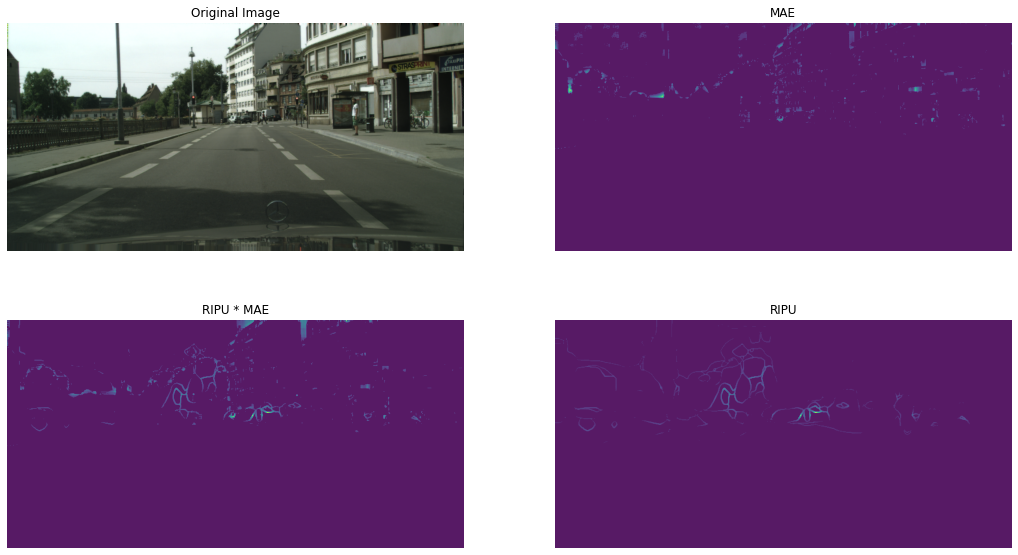

In [18]:
# get RIPU score
pixel_ripu = ripu_engine.get_uncertainties(seg_logit).squeeze(0)
pixel_ripu = pixel_ripu / pixel_ripu.max()
# get MAE score
mae_score = mae_score_engine.compute_score(network=mae_model.cuda(),image=test_data, just_mae=True).squeeze(0)
mae_score = mae_score / mae_score.max()
# get Image
original_image = tensor2image(unnormalize(test_data.squeeze(0), img_norm_cfg))
# Truncations
trunc_mix = np.quantile(mix_score, q=truncation)
mix_score[mix_score < trunc_mix] = 0. 
trunc_ripu = np.quantile(pixel_ripu, q=truncation)
pixel_ripu[pixel_ripu < trunc_ripu] = 0. 
trunc_mae = np.quantile(mae_score, q=truncation)
mae_score[mae_score < trunc_mae] = 0. 

# figure setting
rows, columns = 2, 2
fig = plt.figure(figsize=(18, 10))
# first
fig.add_subplot(rows, columns, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')
# second
fig.add_subplot(rows, columns, 2)
plt.title("MAE")
plt.imshow(mae_score, cmap='viridis', alpha=.9, )
plt.axis('off')
# plt.colorbar()
# third
fig.add_subplot(rows, columns, 3)
plt.title("RIPU * MAE")
plt.imshow(mix_score, cmap='viridis', alpha=.9)
plt.axis('off')
# fourth
fig.add_subplot(rows, columns, 4)
plt.title("RIPU")
plt.imshow(pixel_ripu, cmap='viridis', alpha=.9)
plt.axis('off')
# plt.colorbar()
fig.show()

## compute segmentation loss

In [4]:
seg_ranking, losses = get_seg_ranking(dataset, config=data_config, network=segmenter, loss_fn=F.cross_entropy, return_loss=True)

  0%|          | 0/2975 [00:00<?, ?it/s]/home/yutengli/miniconda3/envs/active/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2975/2975 [01:24<00:00, 35.09it/s]


## compute MAE loss

In [5]:
mae_ranking, mae_losses = get_mae_ranking(dataset, config=data_config, network=mae_model, return_loss=True)

100%|██████████| 2975/2975 [01:24<00:00, 35.01it/s]


## plot image-level correlation

In [8]:
# plot the losses
# FIXME: plot relationship with RIPU too. perhaps MAE score has high relation with ripu
def plot_loss_by_img_level_correlation(order, trunc=None):
    """ order is either seg_ranking or mae_ranking (ascending) """
    reordered_seg_loss = losses[order]
    reordered_mae_loss = mae_losses[order]

    seg_mean, seg_std = reordered_seg_loss.mean(), reordered_seg_loss.std()
    mae_mean, mae_std = reordered_mae_loss.mean(), reordered_mae_loss.std()
    # standardize
    reordered_seg_loss = (reordered_seg_loss - seg_mean) / seg_std
    reordered_mae_loss = (reordered_mae_loss - mae_mean) / mae_std

    if trunc != None:
        assert isinstance(trunc, int)
        reordered_seg_loss = reordered_seg_loss[-trunc:-5]
        reordered_mae_loss = reordered_mae_loss[-trunc:-5]
    print(f"reordered_seg_loss shape: {reordered_seg_loss.shape}")
    print(f"reordered_mae_loss shape: {reordered_mae_loss.shape}")
    # compute coefficient
    corr, _ = pearsonr(reordered_mae_loss, reordered_seg_loss)
    print('Pearsons correlation: %.3f' % corr)
    # visualization
    plt.figure(figsize=(10, 6))
    plt.title('image level correlation (segmentation entropy vs MAE loss)')
    plt.scatter(x=reordered_seg_loss, y=reordered_mae_loss)
    # plt.scatter(x=losses, y=mae_losses) # no re-ordering at all
    plt.xlabel('segmentation entropy')
    plt.ylabel('MAE loss')
    plt.show()


reordered_seg_loss shape: (1185,)
reordered_mae_loss shape: (1185,)
Pearsons correlation: -0.022


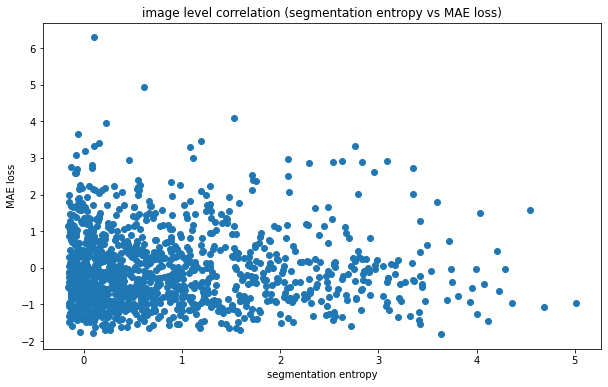

In [14]:
plot_loss_by_img_level_correlation(order=seg_ranking, trunc = int(2975 * 0.4))

## Try pixel wise correlation

In [ ]:
engine(dataset, idx=2090, 
       seg_net=segmenter, mae_net=mae_model,
       mask_ratio=0., plot=True, truncation=0.98)
# segmenter_checkpoint = "work_dirs/multitask_ra_lr5e-4_m50_1500warmup/epoch_5.pth"

In [ ]:
samples = [np.random.randint(2975) for _ in range(100)]
engine_res_max = []
engine_res_top5 = []
for sp in tqdm(samples):
    R = [engine(dataset, sp, seg_net=segmenter, mae_net=mae_model, plot=False) for _ in range(15)]
    T = np.array(R).max() # pick largest
    M = np.array(sorted(R))[-5:].mean() # pick top 5's average
    engine_res_top5.append(M)
    engine_res_max.append(T)

In [16]:
np.array(engine_res_max).shape

(100,)

In [10]:
np.array(engine_res_max).mean()

0.40049504836504746

In [11]:
np.array(engine_res_top5).mean()

0.2194806341865002

## Run on a weaker segmenter

In [12]:
# SECOND SEGMENTER
weak_segmenter_checkpoint = "work_dirs/full_supervision_baseline/iter_16000.pth"
# weak_segmenter_checkpoint = "work_dirs/multitask/epoch_15.pth"
# create config objects
model_cfg = Config.fromfile(segmenter_file)
# create model and load to gpu
weak_segmenter: EncoderDecoder = build_segmentor(
    model_cfg.model, model_cfg.get('train_cfg'), model_cfg.get('test_cfg'))
wrap_fp16_model(weak_segmenter)
_ = load_checkpoint(weak_segmenter, filename=weak_segmenter_checkpoint)

load checkpoint from local path: work_dirs/full_supervision_baseline/iter_16000.pth


there are 110592 sample points. set threshold at 1105.
plotted coeff:  -0.1079


-0.10787892221819467

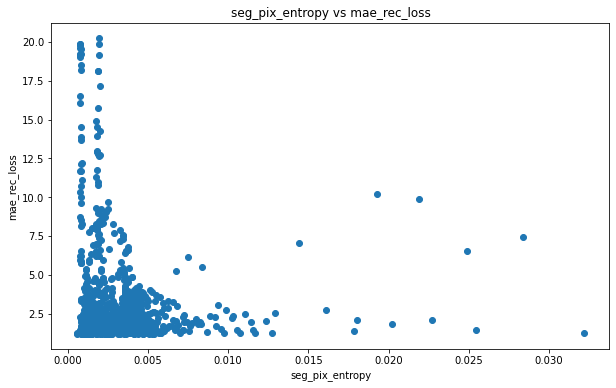

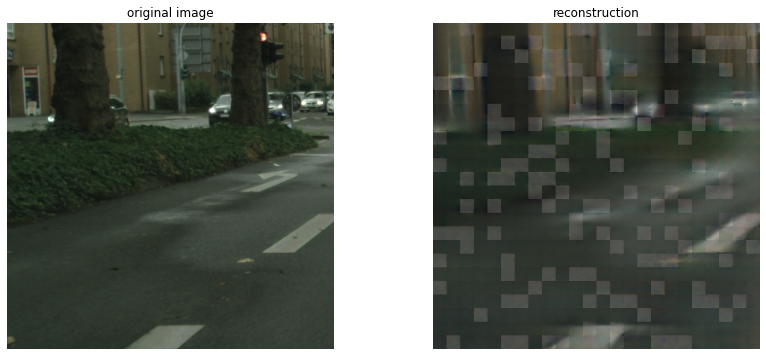

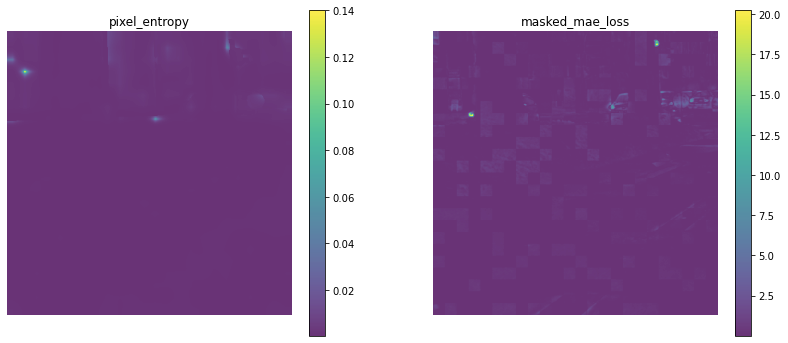

In [13]:
engine(dataset, idx=200, seg_net=weak_segmenter, mae_net=mae_model, plot=True)

In [12]:
samples = [np.random.randint(2975) for _ in range(100)]
w_engine_res_max = []
w_engine_res_top5 = []
for sp in tqdm(samples):
    R = [engine(dataset, sp, seg_net=weak_segmenter, mae_net=mae_model, plot=False) for _ in range(15)]
    T = np.array(R).max() # pick largest
    M = np.array(sorted(R))[-5:].mean() # pick top 4's average
    w_engine_res_top5.append(M)
    w_engine_res_max.append(T)

100%|██████████| 100/100 [05:43<00:00,  3.44s/it]


In [13]:
np.array(w_engine_res_max).mean()

0.4246977546127509

In [14]:
np.array(w_engine_res_top5).mean()

0.2567460164292846

: 